In [1]:
from PIL import Image, ImageDraw
import pandas as pd
import pyarrow as pa
from tqdm import tqdm, trange, tqdm_notebook
from time import sleep
import glob
import os
import re

In [2]:
# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

In [3]:
# Get the physical path to the PNG image containing the mask file
def get_mask_path(tile_x, tile_y, mask_type):
    path = 'E:\\work\\canecrushers\\phase-01\\'
    path += f"data\\sentinel-2a-tile-{tile_x}x-{tile_y}y\\masks\\{mask_type}-mask.png"
    #path += f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    #path = f'E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\'
    return path

mask_path = get_mask_path(TILE_X, TILE_Y, 'sugarcane-region')
print(mask_path)
assert os.path.isfile(mask_path)

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\masks\sugarcane-region-mask.png


In [4]:
def open_image(path, mode = None, verbose = True):
    if verbose:
        print(path)
    img = Image.open(path)
    if mode is not None:
        img = img.convert(mode)
    if verbose:
        print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
        (width, height) = img.size
        print('width:',width,'height:',height)
    return img

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\masks\sugarcane-region-mask.png
Format: None
Size: (512, 512)
Mode: P
width: 512 height: 512


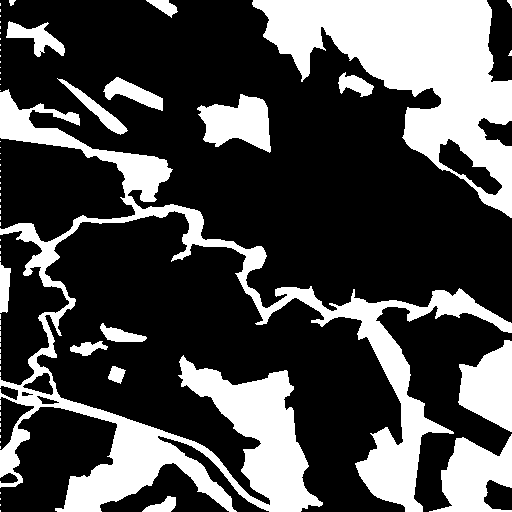

In [5]:
masp = open_image(mask_path, 'P')
masp

In [6]:
# Get a list of all the image tiles for a specific x,y coordinate
# for the specified band
def get_timeseries_image_paths(tile_x, tile_y, band):
    path = 'E:\\work\\canecrushers\\phase-01\\'
    path += f"data\\sentinel-2a-tile-{tile_x}x-{tile_y}y\\timeseries\\{tile_x}-{tile_y}-{band}*.png"
    #print(path)
    images = glob.glob(path)
    return images

In [7]:
tci_list = get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI')
tci_list[-1]

'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-TCI-2019-08-09.png'

In [8]:
def last_date_in_path(path):
    return re.findall('\d{4}-\d{2}-\d{2}',path)[-1]

test_path = tci_list[-1]
print(test_path)
print(last_date_in_path(test_path))

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\7680-10240-TCI-2019-08-09.png
2019-08-09


In [9]:
b_name_list = [f'B{b:02d}' for b in range(1,13)]
b_path_lol = [get_timeseries_image_paths(TILE_X, TILE_Y, b) for b in b_name_list]
b_path_lol[-5][-1]

'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-B08-2019-08-09.png'

In [10]:
def read_img_pixel_values(tile_x, tile_y, date, *args):
    """ return array of arrays 
        one array for each pixel (10m X 10 m), containing 
        an array for each spectrum value for the pixel
    """
    int_max = 2**15-1
    for img in (args):
        assert img.size == args[0].size
    (width, height) = args[0].size
    #print('width',width,'height',height)

    pixl_list = [img.load() for img in args]

    result_list = []
    for x in range(0, width):
        for y in range(0, height):
            val_list = [tile_x, tile_y, x, y, date]
            for pix in pixl_list:
                val = pix[x,y]
                if isinstance(val, tuple):
                    val_list.extend(val)
                    # expand and normalise tuples, basically brighten the shadows
                    #scale = int_max / sum(val)  # scaleing factor to normalise brightness for clouds etc
                    #scale = 100 / sum(val)
                    #norm_list = [int(scale*v) for v in val]
                    #val_list.extend(norm_list)
                else:
                    val_list.append(val)
            #print(val_list)
            result_list.append(val_list)
    return result_list

In [11]:
def write_to_excel(df, file_name, sheet_name='sheet1'):
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheet_name)
    writer.save()

In [12]:
columns = ['tile_x','tile_y','x','y','date','red','green','blue', ]
columns.extend([f'B{b:02d}' for b in range(1,13)])
print(columns)

['tile_x', 'tile_y', 'x', 'y', 'date', 'red', 'green', 'blue', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12']


In [13]:
#for tci_path, b_path_list in tqdm(list(zip(tci_list,b_path_lol))):
assert len(tci_list) == len(b_path_lol[0])
(tile_x, tile_y) = (TILE_X, TILE_Y)
for day_no in trange(len(tci_list)):
    tci_path = tci_list[day_no]
    date = last_date_in_path(tci_path)
    b_path_list = [b_path_list[day_no] for b_path_list in b_path_lol]
    
    tci_img = open_image(tci_path, verbose=False)
    b_img_list = [open_image(b_path, verbose=False) for b_path in b_path_list]
    
    data = read_img_pixel_values(tile_x, tile_y, date, tci_img, *b_img_list)

    df = pd.DataFrame(columns=columns, data=data)
    # apply a very very simple havested ruleS
    df['havested'] = df.apply(lambda df : df.red > df.green, axis=1)
    df['clouds'] = df.apply(lambda df : df.red == df.green and df.red == df.blue, axis=1)

    df.to_parquet(f'image_values_{tile_x}_{tile_y}_{date}.snappy.parquet')
    #df.to_csv(f'image_values_{tile_x}_{tile_y}_{date}.csv.gzip', compression='gzip')


100%|██████████| 71/71 [21:27<00:00, 15.38s/it]


In [ ]:
print(df[df.x==5][df.y==5])